### Run the cell below and wait until the orange pop-up box appears. After it appears, select the Master CSV file that has the source information. 

### After selecting your file, make sure not to run the cell above again or you will have to reselect your file.

In [3]:
import pandas as pd
import numpy as np
import math
import statistics
import operator
import matplotlib.pyplot as plt
import traitlets
from IPython.display import display
from ipywidgets import widgets
from tkinter import Tk, filedialog


class SelectFilesButton(widgets.Button):
    """A file widget that leverages tkinter.filedialog."""

    def __init__(self, *args, **kwargs):
        """Initialize the SelectFilesButton class."""
        super(SelectFilesButton, self).__init__(*args, **kwargs)
        # Add the selected_files trait
        self.add_traits(files=traitlets.traitlets.List())
        # Create the button.
        self.description = "Select Files"
        self.icon = "square-o"
        self.style.button_color = "orange"
        # Set on click behavior.
        self.on_click(self.select_files)

    @staticmethod
    def select_files(b):
        """Generate instance of tkinter.filedialog.
        Parameters
        ----------
        b : obj:
            An instance of ipywidgets.widgets.Button
        """
        # Create Tk root
        root = Tk()
        # Hide the main window
        root.withdraw()
        # Raise the root to the top of all windows.
        root.call('wm', 'attributes', '.', '-topmost', True)
        # List of selected fileswill be set to b.value
        b.files = filedialog.askopenfilename(multiple=True)

        b.description = "Files Selected"
        b.icon = "check-square-o"
        b.style.button_color = "lightgreen"
my_button_1 = SelectFilesButton()
my_button_1


SelectFilesButton(description='Select Files', icon='square-o', style=ButtonStyle(button_color='orange'))

In [4]:
def label_weights(list_labels, weight_dict):
    """
    This function takes in a list of labels and a dictionary to store the information 
    regarding the weights each label had on this particular sentence. When I use the word weight,
    I essentially mean the percent of the turker votes out of all turker votes for that particular label
    for this particular sentence. The weight dictionary has keys for each label and a list of the weight
    that label key had for each sentence. This function returns an updated weight dictionary with
    and the label that got the most votes.
    """
    label_dictionary = {} # create a dictionary to count the label votes
    label_total = 0 # count the total number of labels being considered (weighted)
    vote_total = 0 # count total noumber votes (unweighted)
    
    for label in list_labels:       
        # This handles the case for when the turker picks two labels instead of one 
        if '|' in label:
            label1, label2 = label.split('|') # '|' Separates the two label choices
            if label1 not in label_dictionary:
                label_dictionary[label1] = 0
            label_dictionary[label1] += 1
            label_total += 1
            vote_total +=1
            if label2 not in label_dictionary:
                label_dictionary[label2] = 0
            label_dictionary[label2] += 1
            label_total += 1
            vote_total += 1
            continue
        
        # handles the normal case that the turker didn't pick multiple labels
        # however, add 2 because we expect 10 votes in total
        if label not in label_dictionary:
            label_dictionary[label] = 0
        label_dictionary[label] += 2
        label_total += 2
        vote_total += 1
    max_key = max(label_dictionary, key=label_dictionary.get)
    
    # We'd like to also generate the second label if there is one to make user testing a bit easier
    second_key = " "
    sorted_d = sorted(label_dictionary.items(), key=operator.itemgetter(1))
    if len(sorted_d) >= 2:
        second_key = sorted_d[-2][0]
        # Because I am doing a sort we need to make sure the keys don't match, if they do, then select the tail
        if second_key == max_key:
            second_key = sorted_d[-1][0]
    
    # Add the weights of weights (essentially percent of label population) for each label to the weight dictionary
    for label in weight_dict:
        if label not in label_dictionary:
            weight_dict[label].append(0)
        else:
            weight_dict[label].append(round(label_dictionary[label]/label_total, 2))
    return max_key, second_key, weight_dict, vote_total

In [5]:
def mturk_analysis(file_path, list_turker_counts):
    """ 
Takes in a path to a selected file and a list of numbers representing different mechanical turk votes
and saves a figure of subplots for the distributions of label asssignments for each number of turkers in the list. 
It also saves csv files for the analysis of the label assignments (i.e. std, avg, etc.), a csv of all the label
and sentence assignments for the entire set, and a csv of label and sentence assignments that are to be used 
for the training and testing sets. All of this is saved to the file path where the input file was selected from.
    """
    
    data_set = pd.read_csv(file_path[0]).loc[ : , ["Input.text","Answer.Label", "Answer.Severity", "Answer.isStress", "Answer.isCOVID"]]
        
    # Filter data (Bug Fix #9)
    for i, row in data_set.iterrows():
        if '|' not in row['Answer.Label'] and 'Not Stressful' in row['Answer.Label']:
             data_set.at[i,'Answer.Label'] = 'Other'
        elif '|' in row['Answer.Label']:
            label1, label2 = row['Answer.Label'].split('|')
            if label1 == 'Not Stressful' and label2 != 'Other':
                data_set.at[i,'Answer.Label'] = 'Other|' + label2
            elif label1 == 'Not Stressful' and label2 == 'Other':
                data_set.at[i,'Answer.Label'] =  label2
    
    plt.figure(figsize=(10, 20)) # setting size of plots
    iteration = 1
    for number in list_turker_counts:
        mturk_maindf = mturk_auto(data_set, number)
        
        # initializing the dataframe with source info to merge with main dataframe
        df_sources = pd.read_csv(my_button_1.files[0])[['Source', 'Answer.Stressor', 'sID', 'Answer.Label', 'is_seed']]
        
        # replacing all "Unknown" labels in Master CSV with "Other"
        og_label = df_sources['Answer.Label'].tolist()
        for i in range(len(og_label)):
            if og_label[i] == 'Unknown':
                og_label[i].replace("Unknown", "Other")
        mturk_maindf.insert(5, 'original_label', og_label)
        
        
        df_source_included = pd.merge(left=mturk_maindf, right=df_sources, left_on='Input.text', right_on='Answer.Stressor')
#         df_source_included.drop_duplicates(subset='sID', inplace=True)
        df_source_included.sort_values(by='sID', inplace=True) # sort by sID after combining
        
        #rearrage order of columns
        sID = df_source_included['sID'].tolist() 
        
        # Drop the extra sentence columns
        df_source_included.drop(columns=['Answer.Label', 'Answer.Stressor', 'sID'], inplace=True) 
        df_source_included.insert(0, 'sID', sID)
        
        #create plot
        make_plot(mturk_maindf, len(list_turker_counts), iteration, number)
        
        #saving all files to computer
        pd.DataFrame(df_source_included).to_csv("Main turk aggregation of " + str(number) + " turkers" + ".csv", index=False, header=True)
        iteration += 1
    plt.savefig("INSERT FIG NAME HERE " + "turkers" + ".png", bbox_inches='tight')

In [6]:
def sorted_dict(unsorted_dictionary):
    """
    This function takes in a counts dictionary, a dictionary with labels as keys
    and counts for the number of times that labels has been assigned to a sentence as values,
    and returns the same dictionary, but the keys are in alphabetical order. 
    The motivation for this is to create plots with a uniform labeling system on the y-axis. 
    """
    sort_vector = []
    sorted_dict = {}
    for label in unsorted_dictionary:
        sort_vector.append(label)
    sort_vector.sort()
    for key in sort_vector:
        sorted_dict[key] = unsorted_dictionary[key]
    return sorted_dict

In [7]:
def make_plot(main_dataframe, total_count, number, turker_num):
    """
    This function takes in a dictionary in the form of the dictionary returned from labelsent_dict,
    the number of turker votes being considered (i.e. [1, 3, 5] would equal 3 for total_count),
    the amount of times this iteration of this function has been called, and the current turker vote
    amount that is being considered. This returns an annotated figure of subplots that allow for the user
    to observe the differences in label assignment with different numbers of turkers.
    """
    # The plot can only be made from values (or "counts") so this counts the number of label assignments per label
    counts_dict = make_count_dict(main_dataframe)
    sort_dict = sorted_dict(counts_dict)
    # creates the values for the plot
    keys = list(sort_dict.keys())
    values = list(sort_dict.values())
    
    # Creates the subplot at certain region in figure
    plt.subplot(total_count, 1, number)
    plt.title("Plot for " + str(turker_num) + " turkers") # helps differentiate each subplot 
    plt.barh(keys, values)
    
    # plots the values of the bars on the plot
    for index, value in enumerate(values):
        plt.text(value, index, str(value))

In [8]:
def make_count_dict(main_dataframe):
    """
    Takes in a dictionary of the form that is returned from the labelsent_dict function
    and returns a dictionary that has the keys as labels and counts of the number of times
    that label has been assigned as the values.
    """
    counts_of_labels = {}
    for label in main_dataframe['top_label'].tolist():
        if label not in counts_of_labels:
            counts_of_labels[label] = 0
        counts_of_labels[label] += 1
    return counts_of_labels

In [9]:
def make_dictionary(dataframe):
    """
    This function takes in the dataframe that is generated from the csv file
    and creates a dictionary containing all the labels to initialize the label weight dictionary
    that is going to hold the weight that label had on each sentence. 
    This dictionary has labels as the key and a list of weight as the value. 
    """
    
    label_weight_dict = {} # initialize dictionary
    
    # handles the case where turker only voted with one label
    for label in dataframe['Answer.Label']:
        if '|' not in label:
            if label not in label_weight_dict:
                label_weight_dict[label] = []
     
    # separetely handles the case for when turker has two label votes
    for label in dataframe['Answer.Label']:
        if '|' in label:
            label1, label2 = label.split('|')
            if label1 not in label_weight_dict:
                label_weight_dict[label] = []
            if label2 not in label_weight_dict:
                label_weight_dict[label] = []
                
    return label_weight_dict

In [10]:
def sentence_occurrence_count(data_frame):
    """
    This takes in a dataframe that was produced from reading in the csv file that was selected
    and returns the number of sentence repetitions per sentence. 
    Essentially how many turker votes per sentence there are.
    """
    data_frame = data_frame['Input.text'].tolist() # creates list of sentences in the csv file
    count = 0
    last = data_frame[0]
    while data_frame[count] == last:
        count += 1
    return count

In [16]:
def is_stressor(list_stressor):
    """
    this takes in a list of stressor votes (i.e. is a stressor OR not a stressor) and returns 'True' 
    if the amount of votes for if it were a stressor were the majority and False otherwise. 
    It also returns the percent of the set population that elected the winning vote.
    """
    stressor_conf = 0
    for stressor in list_stressor:
        stressor_conf += stressor
    value = stressor_conf/len(list_stressor)
    
    # making sure that half is rounded up to 1
    if value == 0.5:
        value = 1
        
    if round(value) == 1: # if its greater than 50% it will round to 1, else 0
        return 'True', (stressor_conf/len(list_stressor)) * 100
    return 'False', (round(((len(list_stressor) - stressor_conf)/len(list_stressor)), 2)) * 100    

In [12]:
def mturk_auto(data_frame, number):
    """ 
    This Function takes in a DataFrame and a number of turker votes being considered at this iteration.
    Returns a dictionary that contains the label assignments with corresponding sentences, and analysis
    of severity of each stressor. 
    
    """          
    
    # These are the things we want in our dictionary
    mturk_dict = {'Input.text':[], 'is_stressor': [], 'is_stressor_conf': [], 'is_covid': [], 'is_covid_conf': [], 'top_label': [], 'second_label': [],'avg_severity':[], 'median_severity':[], 'SD_severity': [], 'Votes': []}
    label_weight_dict = make_dictionary(data_frame) # initializing weight dictionary
    
    # make everyrthing a list so it is easier to iterate over
    label_list = data_frame["Answer.Label"].tolist()
    severity_list = data_frame["Answer.Severity"].tolist()
    stressor_list = data_frame["Answer.isStress"].tolist()
    covid_list = data_frame["Answer.isCOVID"].tolist()
    input_text = data_frame["Input.text"].tolist()
    
    sentence_count = sentence_occurrence_count(data_frame) # How many turkers vote on a single sentence
    count = len(label_list)/sentence_count # How many groups of sentences are there to loop through
    
    last = 0
    for i in range(int(count)):
        place = last
        
        #Create sublists to determine the majority vote
        label_set = label_list[place: place + number]
        stressor_set = stressor_list[place : place + number]
        covid_set = covid_list[place : place + number]
        severity_set = severity_list[place : place + number]
        
        
        #Get the label and stressor assignment and update weight dictionary
        max_key, second_key, label_weight_dict, num_votes = label_weights(label_set, label_weight_dict)
        boolean, confidence = is_stressor(stressor_set)
        
        #Since it is the same operation and format as is_stressor, we can reuse function
        boolean_covid, confidence_covid = is_stressor(covid_set)
        
        #Append all variables to the main dictionary
        mturk_dict['top_label'].append(max_key)
        mturk_dict['second_label'].append(second_key)
        
        if boolean == 'True':
            mturk_dict['is_stressor'].append(1)
        else: 
            mturk_dict['is_stressor'].append(0)
        
        if boolean_covid == 'True':
            mturk_dict['is_covid'].append(1)
        else: 
            mturk_dict['is_covid'].append(0)
            
        mturk_dict['is_stressor_conf'].append(str(confidence) + '%') # To make it look better on csv or excel
        mturk_dict['is_covid_conf'].append(str(confidence_covid) + '%') # To make it look better on csv or excel
        mturk_dict['avg_severity'].append(np.average(severity_set))
        mturk_dict['median_severity'].append(np.median(severity_set))
        mturk_dict['SD_severity'].append(round(np.std(severity_set), 2)) # rounding to two integers looks better
        mturk_dict['Input.text'].append(input_text[place])
        mturk_dict['Votes'].append(num_votes)
        last = place + sentence_count
        
    mturk_dict = {**mturk_dict , **label_weight_dict} # combining the dicitonarys to form one big dictionary
    return pd.DataFrame(mturk_dict) # converting to dataframe

## After running the cell below, wait until the orange button appears and select the csv file that is the mturk data that you want to be analyzed. 

In [13]:
import pandas as pd
import numpy as np
import math
import statistics
import operator
import matplotlib.pyplot as plt
import traitlets
from IPython.display import display
from ipywidgets import widgets
from tkinter import Tk, filedialog


class SelectFilesButton(widgets.Button):
    """A file widget that leverages tkinter.filedialog."""

    def __init__(self, *args, **kwargs):
        """Initialize the SelectFilesButton class."""
        super(SelectFilesButton, self).__init__(*args, **kwargs)
        # Add the selected_files trait
        self.add_traits(files=traitlets.traitlets.List())
        # Create the button.
        self.description = "Select Files"
        self.icon = "square-o"
        self.style.button_color = "orange"
        # Set on click behavior.
        self.on_click(self.select_files)

    @staticmethod
    def select_files(b):
        """Generate instance of tkinter.filedialog.
        Parameters
        ----------
        b : obj:
            An instance of ipywidgets.widgets.Button
        """
        # Create Tk root
        root = Tk()
        # Hide the main window
        root.withdraw()
        # Raise the root to the top of all windows.
        root.call('wm', 'attributes', '.', '-topmost', True)
        # List of selected fileswill be set to b.value
        b.files = filedialog.askopenfilename(multiple=True)

        b.description = "Files Selected"
        b.icon = "check-square-o"
        b.style.button_color = "lightgreen"
my_button = SelectFilesButton()
my_button


SelectFilesButton(description='Select Files', icon='square-o', style=ButtonStyle(button_color='orange'))

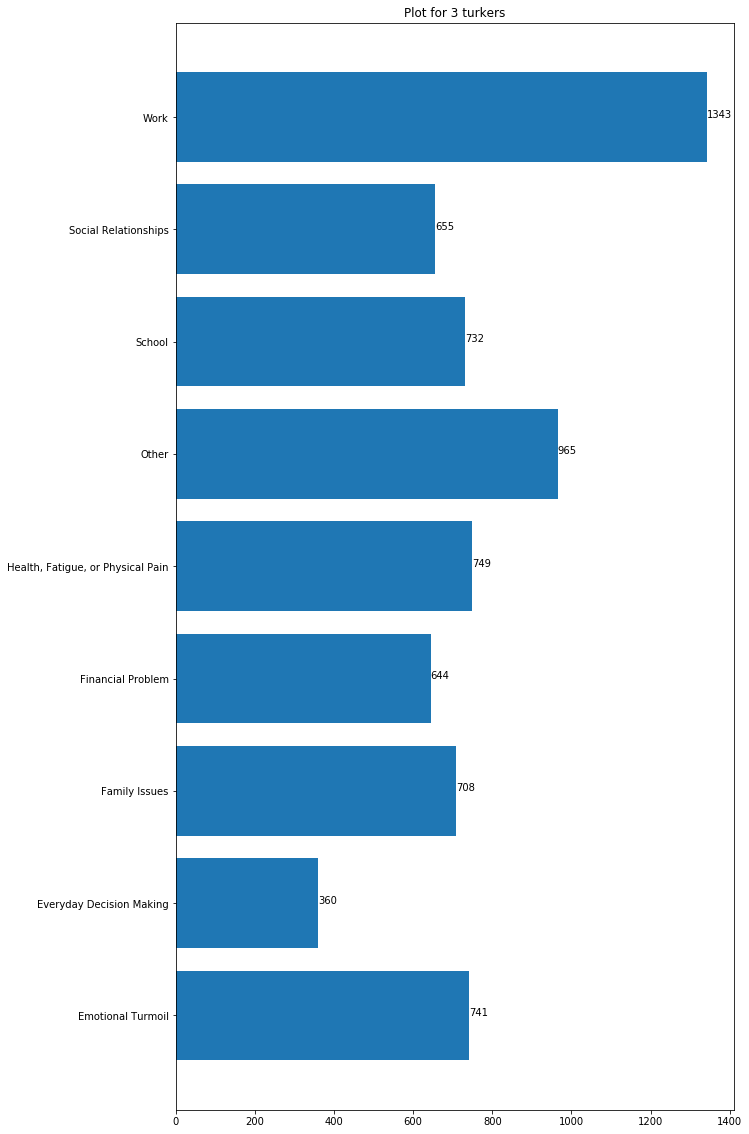

In [17]:
# Make sure that the second argument parameter is a list. Even if it is one number, put it in brackets. 
mturk_analysis(my_button.files, [3])